# Load MCMC set up notebook

In [23]:
!pip install pdflatex

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: attrs
    Found existing installation: attrs 21.4.0
    Uninstalling attrs-21.4.0:
      Successfully uninstalled attrs-21.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest 7.0.1 requires attrs>=19.2.0, but you have attrs 18.2.0 which is incompatible.


In [5]:
import os
os.chdir('/home/tzd/fs03/d1/tzd/Data_analysis/MIT_TPP_thesis/JPnotebooks/')
%run MCMC_Method_ObservationData_95th_mean_IQR.ipynb


boxes().shape[0]
# getNoASGM():       => Hg0no_ASGM dataframe; in correct units
# get_model(region): => Hg0_modified; in correct units (takes gridbox region in Peru as input)
# getLoRes():        => Hg0 baseline with ASGM low resulution in correct units
# getHiRes():        => Hg0 baseline with ASGM high resulution in correct units
# getNoASGM():       => Hg0 baseline without ASGM low resulution in correct units
# get_obs_d():       => obs_Hg0; original observations daily mean values
# get_detrended_obs(): => Obs_detrended; return detrended observations
# get_detrended_model(model): => This function takes in a dataframe of model outputs 
                                and returns the detrended version of that model output
# getObsIQR(obs): This function takes observations and returns the IQR 
# getIQR_Dd(model): This function takes in a dataframe of model outputs and returns the detrended IQR
# getIQR(model): => This function takes in a dataframe of model outputs and returns the IQR
#

/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [6]:
import warnings
from math import sqrt
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In [7]:
#os.chdir('/home/tzd/fs03/d1/tzd/Data_analysis/RAworkflow')

# Plot functions

In [8]:
def plotChain(sampler):
    #%% Plot chain results
    fig= plt.figure( figsize=[8,5])
    ax= fig.add_subplot(111)
    res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
    SPuno_truval = scalors['spun'][0]
    plt.axhline(SPuno_truval, color='blue')
    ax.set_ylabel('Hg$^0$ emissions (Mt yr$^{-1}$)', fontsize = 14)
    ax.set_xlabel('Length of Chains')
    plt.show()

In [9]:
def plotCorner(sampler,title):
    #%% Plot corner plots to visualize 1D and 2D spreads between the parameters we are testing, and get some uncertainties on our paraemter estimations
    #True_Emissions = [7.748216414, 11.66649464,1.38677, 13.6339, 18.9904]
    labels = ['South Puno','North Puno','Madre de Dios','Arequipa','Apurimac']
    samples = sampler.flatchain
    fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.025, 0.5, 0.975])#,truths=True_Emissions,truth_color='blue'
    fig.suptitle(title,x=0.6,fontsize=16,fontweight="bold")
    return fig

In [44]:
def plotBox(sampler,title):
    samples = sampler.flatchain
    labels = ['South Puno','North Puno','Madre de Dios','Arequipa','Apurimac']
    dfSamples=pd.DataFrame(samples,columns=labels)
    dfSamples['Puno']=dfSamples['South Puno']+dfSamples['North Puno']
    dfSamples=dfSamples[['Puno','Madre de Dios','Arequipa','Apurimac']]
    
    fig= plt.figure( figsize=[12,5])
    #plt.rc('pgf', texsystem='pdflatex')
    ax= fig.add_subplot(111)
    bpdict = dfSamples.boxplot(whis=[5, 95], return_type='dict')
    posi=[0.05,0.20,0.3,0.45,0.55,0.7,0.8,0.95]

    #ax.axhline(7.75,xmin=0, xmax=0.20,color = 'blue',label='GMA18: 7.75 Mt')
    ax.axhline(19.42,xmin=posi[0], xmax=posi[1],color = 'orange',label='GMA18: 19.42 t')
    ax.axhline(1.39, xmin=posi[2], xmax=posi[3],color = 'green',label='GMA18: 1.39 t')
    ax.axhline(13.63, xmin=posi[4], xmax=posi[5],color = 'red',label='GMA18: 13.63 t')
    ax.axhline(18.99, xmin=posi[6], xmax=posi[7],color = 'darkviolet',label='GMA18: 18.99 t')
    ax.axhline(19.73, xmin=posi[0], xmax=posi[1],color = 'orange',linestyle = '--',label='AGC Puno: 19.73 t')
    ax.axhline(54.46,xmin=posi[2], xmax=posi[3],color='green',linestyle = '--',label='AGC Madre de Dios: 54.46 t')
    ax.axhline(23.86,xmin=posi[4], xmax=posi[5],color='red',linestyle = '--',label='AGC Arequipa: 23.86 Mt')
    ax.axhline(10,xmin=posi[6], xmax=posi[7],color='darkviolet',linestyle = '--',label='AGC Cusco + Ayacucho: 10 t')
    lgd=ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    ax.set_ylabel('Hg$^0$ emissions (t yr$^{-1}$)',fontsize=12,fontweight="bold")
    ax.set_title(title, fontsize=12,fontweight="bold")
    plt.grid(False)
    plt.ylim(-2, 105)
    plt.show()
    name='MCMC_Estimates'+metric
    savepath='/home/tzd/fs03/d1/tzd/Data_analysis/MIT_TPP_thesis/figures/MCMC'+name+'.pdf'
    fig.savefig(savepath,bbox_extra_artists=(lgd,), bbox_inches='tight')
    return fig

In [12]:
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# Invetigations to be carried out description


We are using the MCMC algorithm to figure out the distributions of 5 different parameters using different metrics. The metrics being used to compare the Hg concentrations time series are:
* Mean 
* IQR
* 95th percentile range 

With each of these metrics, we investigate the following:
* The effect of the number of sites used as reference by the algorithm
* The effect of the size of the error

# Comparing the different metrics against each other


To compare the metrics against each other we need to choose the error that we are going to use and the number of sites.
1. Error=0.00001
2. Number of Sites =5

## Run simulations and store samples from the  Metrics

In [13]:
data = obs_Hg0_d['value']
res = bootstrap((data,),  np.mean)
y_err = (np.array(res.standard_error)).mean()

init = np.array([7.75, 11.67,1.39, 13.63, 18.99]) #[7.75, 11.66, 50, 23.86, 10]
metrics=['mean','95th','iqr']
error=y_err
ref_sites=0
super_metric_dict={}
for metric in metrics:
     #select the model based on the metric being used
    model = set_metric(metric)
    # initialize the constant teerms based on the right model
    ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(ref_sites)
    #run MCMC simulation
    sampler=run_simulation(ref_sites,metric,init)
    super_metric_dict[metric]= sampler
    #create corner plot

model metric is mean
The true value of y is: 0.902002085404224 

the error is: 0.007753690598712379
Running burn-in...
Running production...
model metric is 95th percentile
The true value of y is: 0.5756446123123166 
 
the error is: 0.059121952976583986
Running burn-in...
Running production...
model metric is IQR
Running burn-in...
Running production...


## Create Plots for the different Metrics

### create function for finding absolute error

In [14]:
#create function for finding absolute error
def calc_absE(sampler):
    samples = sampler.flatchain
    labels = ['South Puno','North Puno','Madre de Dios','Arequipa','Apurimac']
    dfSamples=pd.DataFrame(samples,columns=labels)
    dfSamples['Puno']=dfSamples['South Puno']+dfSamples['North Puno']
    dfSamples=dfSamples[['Puno','Madre de Dios','Arequipa','Apurimac']]
#     print('\n')
#     print(dfSamples.describe())
    df_pred=dfSamples.mean()
    df_true=pd.DataFrame([{'Puno':19.73,'Madre de Dios':54.46,'Arequipa':23.86,'Apurimac':10}])
    #df_preVtrue['trueVal']=  df_true[0]
    #print(df_preVtrue)
    print('\n')
    df_abse=abs(df_pred-df_true)
#     print(df_abse.T[0].to_dict())
#     print('\n')
    new_samples =  sampler.flatchain
    new_samples[np.argmax(sampler.flatlnprobability)]
    mse = mean_squared_error(np.array([7.75, 11.66, 50, 23.86, 10]),new_samples[np.argmax(sampler.flatlnprobability)])
            # calculate rmse
    rmse = sqrt(mse)
    return df_abse.T[0].to_dict()

In [15]:
# sampler=super_metric_dict['mean']
# new_samples =  sampler.flatchain
# new_samples[np.argmax(sampler.flatlnprobability)]
# mse = mean_squared_error(7.75,new_samples[np.argmax(sampler.flatlnprobability)][0])
# 		# calculate rmse
# rmse = sqrt(mse)

# # evaluate_forecasts

In [31]:

samples =super_metric_dict['95th'].flatchain
labels = ['South Puno','North Puno','Madre de Dios','Arequipa','Apurimac']
dfSamples=pd.DataFrame(samples,columns=labels)
dfSamples['Puno']=dfSamples['South Puno']+dfSamples['North Puno']
dfSamples=dfSamples[['Puno','Madre de Dios','Arequipa','Apurimac']]
dfSamples.describe()

,Puno,Madre de Dios,Arequipa,Apurimac
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,25.016892,21.259259,37.294538,17.653958
std,13.930590,16.733787,26.201755,13.646672
min,0.198952,0.004300,0.001057,0.000503
25%,14.344235,7.843288,15.270540,6.808473
50%,22.975337,17.362920,32.637063,14.748762
75%,33.741459,31.188494,56.108410,25.393574
max,89.494962,99.085880,99.993943,91.189833


In [37]:
pct5=dfSamples.quantile(q=0.05, axis=0, numeric_only=True, interpolation='linear')
pct95=dfSamples.quantile(q=0.95, axis=0, numeric_only=True, interpolation='linear')
print(pct5)
print('\n')
print(pct95)

Puno             5.846989
Madre de Dios    1.361217
Arequipa         2.881697
Apurimac         1.361258
Name: 0.05, dtype: float64


Puno             51.044720
Madre de Dios    54.136724
Arequipa         87.140646
Apurimac         44.364885
Name: 0.95, dtype: float64


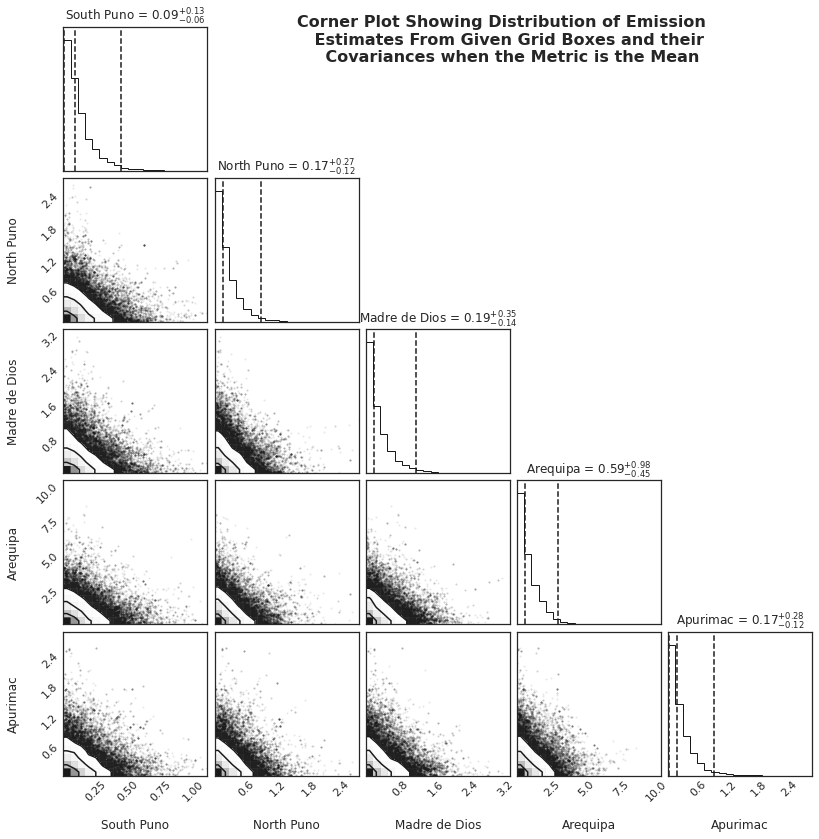

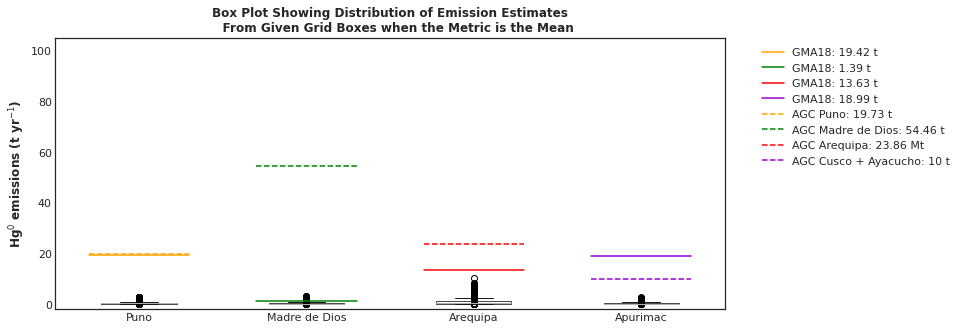

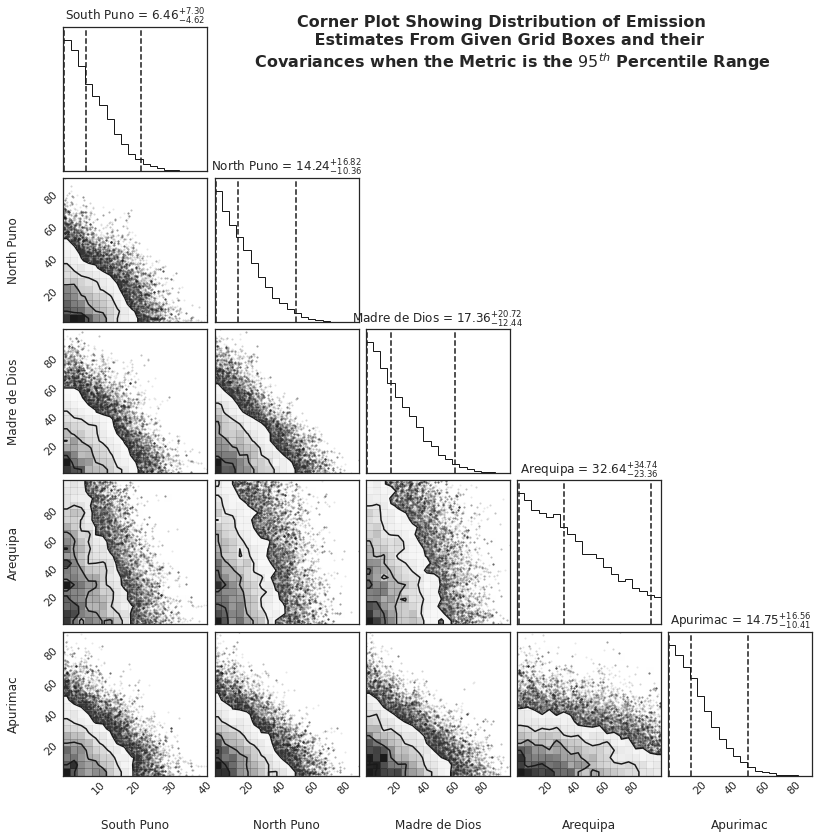

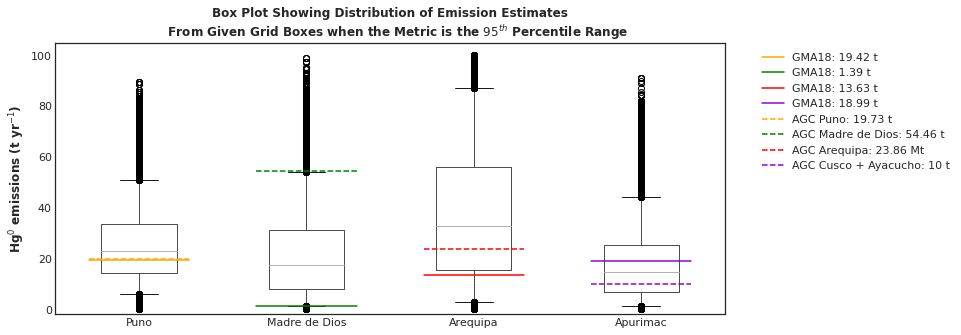

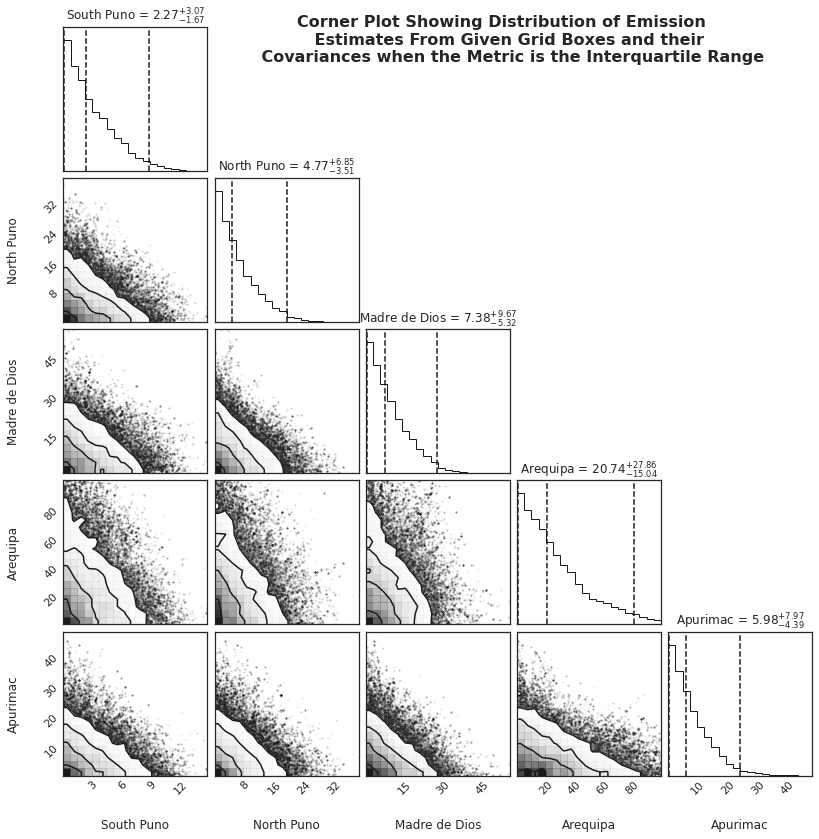

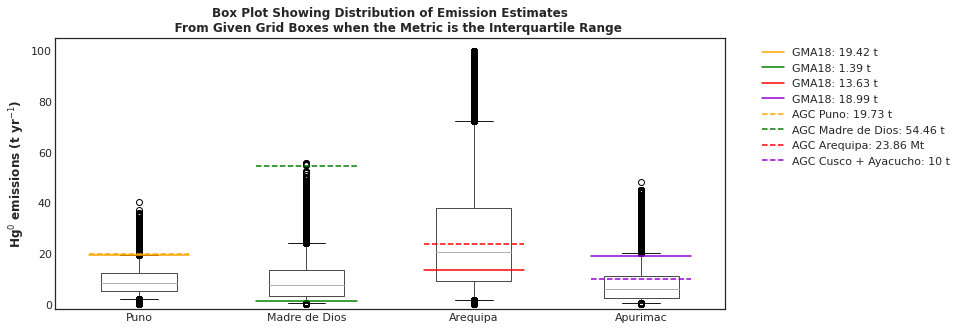

In [45]:

CompareMetric={}

for metric in metrics:
    if metric=='mean':
        met='Mean'
    elif metric=='95th':
        met= '$95^{th}$ Percentile Range'
    else:
        met= 'Interquartile Range'
    sampler=super_metric_dict[metric]
    #create corner plots
    corner_title= '''Corner Plot Showing Distribution of Emission
    Estimates From Given Grid Boxes and their 
    Covariances when the Metric is the '''+met
    
    plotCorner(sampler,corner_title)
    #create boxplot 
    box_title= '''Box Plot Showing Distribution of Emission Estimates
    From Given Grid Boxes when the Metric is the '''+met 
    #df_metric['Puno']=df_metric['South Puno']+df_metric['North Puno']
    plotBox(sampler,box_title)
    #df_metricv2=df_metric[['Madre de Dios','Arequipa','Apurimac','Puno']]
    
    # store dataframe of emission estimate distibutions iqr in dictionary
    #find absolute mean error between mode of MCMC and the true values 
    # df_preVtrue=df_metric.mode().T
    # df_preVtrue['trueVal']= np.array([19.73,54.46, 23.86, 10])
    # df_abse=abs(df_preVtrue['trueVal']-df_preVtrue[0])
    df_abse=calc_absE(sampler)
    CompareMetric[metric]= df_abse

## Plot Absolute Error

In [ ]:
pd.DataFrame(CompareMetric).T

,Puno,Madre de Dios,Arequipa,Apurimac
mean,19.412873,54.211972,23.099974,9.737287
95th,4.735345,33.417726,13.342262,7.502097
iqr,10.230738,45.416354,1.278572,2.564286


In [ ]:
CompareMetric

{'mean': {'Puno': 19.412872834843274,
  'Madre de Dios': 54.2119720427339,
  'Arequipa': 23.099973918975085,
  'Apurimac': 9.737286520858973},
 '95th': {'Puno': 4.735345092775518,
  'Madre de Dios': 33.417725609384036,
  'Arequipa': 13.342261788585674,
  'Apurimac': 7.502096703759552},
 'iqr': {'Puno': 10.230738448006981,
  'Madre de Dios': 45.41635437435738,
  'Arequipa': 1.278572363020313,
  'Apurimac': 2.564286478263229}}

           Puno  Madre de Dios   Arequipa  Apurimac
mean  19.412873      54.211972  23.099974  9.737287
95th   4.735345      33.417726  13.342262  7.502097
iqr   10.230738      45.416354   1.278572  2.564286


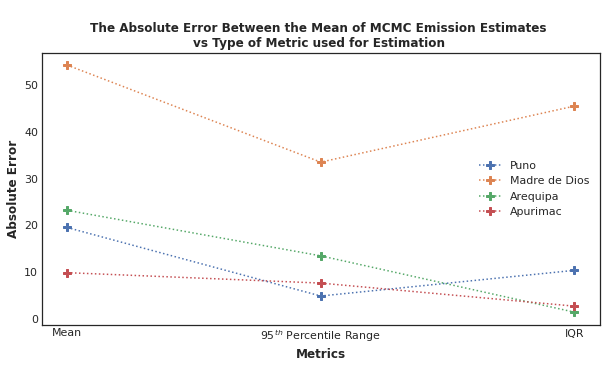

In [ ]:
df_CompareMetric=pd.DataFrame(CompareMetric).T
regs=['Puno','Madre de Dios','Arequipa','Apurimac']
df_CompareMetric.rename(columns={0:regs[0],1:regs[1],2:regs[2],3:regs[3]},inplace=True)
print(df_CompareMetric)
fig= plt.figure( figsize=[10,5])
err_text=str("{:.2e}".format(error))
Title='''
The Absolute Error Between the Mean of MCMC Emission Estimates 
vs Type of Metric used for Estimation '''
ax= fig.add_subplot(111)
ax.set_title(Title, size=12,fontweight="bold")
ax.set_ylabel('Absolute Error', fontsize = 12,fontweight="bold")
ax.set_xlabel('Metrics', fontsize = 12,fontweight="bold")
for reg in regs:
    ax.plot(['Mean','$95^{th}$ Percentile Range','IQR'],df_CompareMetric[reg],'P:',ms = 8,label=reg)
ax.legend()
plt.show()
    

# Create plots showing how the error of the posterior emission distibutions change as the error term in the simulation decreases

## Using IQR as Metric

### Generate simulation results

In [ ]:
#calculate initial error based on data
data = obs_Hg0_d['value']
res = bootstrap((data,),  fun_iqr)
y_err = (np.array(res.standard_error)).mean()
y_err
#specify the number of sites
ref_sites=0 # 0 is equivalent to one site 
#initialize the priors
init = np.array([7.75, 11.66, 54, 23.86, 1.5]) 
#set up dictionary for capturing the IQRs for each error per site
error_dict={}
iqr_super_dict={}
for i in range(2,20,2):
    print("The error in this is run: ",y_err)
    metric = 'iqr'
    model = set_metric(metric)
    ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(ref_sites)
    sampler=run_simulation_error(ref_sites,metric,init,y_err)
    
    #store simulation results in the super dictionary
    iqr_super_dict[i]=sampler
    error_dict[i]=y_err
    y_err=y_err*(0.5**i)   


The error in this is run:  0.011306015245114494
model metric is IQR
Running burn-in...
Running production...
The error in this is run:  0.0028265038112786234
model metric is IQR
Running burn-in...
Running production...
The error in this is run:  0.00017665648820491397
model metric is IQR
Running burn-in...
Running production...
The error in this is run:  2.7602576282017807e-06
model metric is IQR
Running burn-in...
Running production...
The error in this is run:  1.0782256360163206e-08
model metric is IQR
Running burn-in...
Running production...
The error in this is run:  1.052954722672188e-11
model metric is IQR
Running burn-in...
Running production...
The error in this is run:  2.5706902408988967e-15
model metric is IQR
Running burn-in...
Running production...
The error in this is run:  1.569024805236143e-19
model metric is IQR
Running burn-in...
Running production...
The error in this is run:  2.394141853692845e-24
model metric is IQR
Running burn-in...
Running production...


### Generate the Corner plots and Box plots for IQR

FileNotFoundError: [Errno 2] No such file or directory: 'MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/cornerplot_IQR2.png'

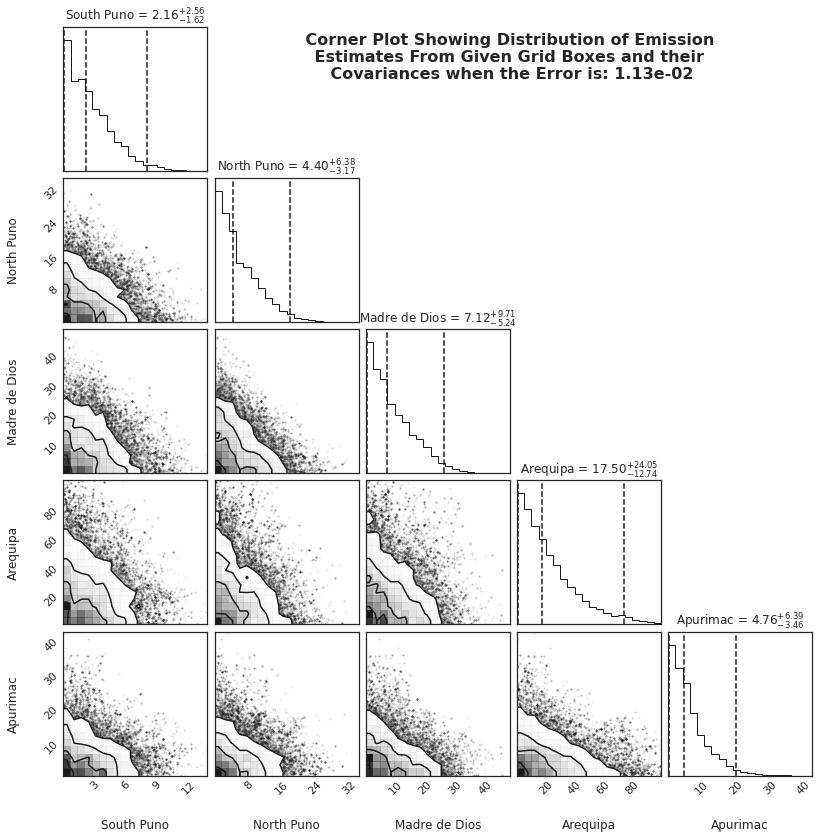

In [ ]:

iqr_errorVerror={}
for i in range(2,20,2):
    y_err=error_dict[i]
    
    sampler=iqr_super_dict[i]
    # plot corner 
    corner_title= '''
    Corner Plot Showing Distribution of Emission 
    Estimates From Given Grid Boxes and their 
    Covariances when the Error is: '''+str("{:.2e}".format(y_err))
    cornerplot=plotCorner(sampler,corner_title)
    CornerFigName='cornerplot_IQR'+str(i)
    cornerplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+CornerFigName)
    
    #plot boxplot
    box_title= '''
    Box Plot Showing Distribution of Emission Estimates
    From Given Grid Boxes when the Error is: '''+str("{:.2e}".format(y_err))
    boxplot=plotBox(sampler,box_title)
    BoxFigName='boxplot_IQR'+str(i)
    boxplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+ BoxFigName)
    #rangeVerror[y_err]=df.apply(find_iqr)
    #y_err=y_err*0.5
    err_sci=str("{:.2e}".format(y_err))
    # df_preVtrue=df_iqr.mode().T
    # df_preVtrue['trueVal']=np.array([19.73,54.46, 23.86, 10])
    # df_abse=abs(df_preVtrue['trueVal']-df_preVtrue[0])
    df_abse=calc_absE(sampler)
    iqr_errorVerror[err_sci]= df_abse
    


### Plot Absolute Errors for IQR

In [ ]:
df_rangeVerror=pd.DataFrame(iqr_errorVerror).T 
df_error=df_rangeVerror.reset_index()
fig= plt.figure( figsize=[16,8])
ax= fig.add_subplot(111)
df_error[['Puno','Madre de Dios','Arequipa','Apurimac']].plot(ax=ax)
xtics=list(df_error['index'])


Title='''
How the Absolute Error Between the Mode of MCMC Emission Estimates and the AGC 
Emission Estimates changes as the Error used in the MCMC Run when the Metric is the IQR'''

ax.legend()
ax.set_ylabel('Absolute Error', fontsize = 14,fontweight="bold")
ax.set_xlabel('Error Used in MCMC Run', fontsize = 14,fontweight="bold")
ax.set_title(Title, size=18,fontweight="bold")
ax.set_xticks(list(range(len(xtics))))
ax.set_xticklabels(xtics)
plt.ylim(-2, 80)
plt.show()
fig.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/abs_errorVmcmc_error_iqr')

## Using 95th as Metric

### Generate the simulation results

In [ ]:
#calculate initial error based on data
data = obs_Hg0_d['value']
res = bootstrap((data,),  fun_95th)
y_err = (np.array(res.standard_error)).mean()
y_err
#specify the number of sites
ref_sites=0 # 0 is equivalent to one site 
#initialize the priors
init = np.array([7.75, 11.66, 54, 23.86, 1.5]) 
#set up dictionary for capturing the IQRs for each error per site
error_dict_95th={}
super_dict_95th={}
for i in range(2,20,2):
    print("The error in this is run: ",y_err)
    metric = '95th'
    model = set_metric(metric)
    ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(ref_sites)
    sampler=run_simulation_error(ref_sites,metric,init,y_err)
    
    #store simulation results in the super dictionary
    super_dict_95th[i]=sampler
    error_dict_95th[i]=y_err
    y_err=y_err*(0.5**i)   

### Generate the Corner plots and Box plots for 95th % range

In [ ]:

errorVerror_95th={}
for i in range(2,20,2):
    y_err=error_dict_95th[i]
    
    sampler=super_dict_95th[i]
    # plot corner 
    corner_title= '''
    Corner Plot Showing Distribution of Emission 
    Estimates From Given Grid Boxes and their 
    Covariances when the Error is: '''+str("{:.2e}".format(y_err))
    cornerplot=plotCorner(sampler,corner_title)
    CornerFigName='cornerplot_95th'+str(i)
    cornerplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+CornerFigName)
    #plot boxplot
    box_title= '''
    Box Plot Showing Distribution of Emission Estimates
    From Given Grid Boxes when the Error is: '''+str("{:.2e}".format(y_err))
    boxplot=plotBox(sampler,box_title)
    BoxFigName='boxplot_95th'+str(i)
    boxplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+ BoxFigName)
    #rangeVerror[y_err]=df.apply(find_iqr)
    #y_err=y_err*0.5
    err_sci=str("{:.2e}".format(y_err))
    
    # df_preVtrue=df_95th.mode().T
    # df_preVtrue['trueVal']=np.array([19.73,54.46, 23.86, 10])
    # df_abse=abs(df_preVtrue['trueVal']-df_preVtrue[0])
    df_abse=calc_absE(sampler)
    errorVerror_95th[err_sci]= df_abse

In [ ]:
def model95th(theta):
            """Dummy model used here for Bayesian analysis (replace with actual GEOS-Chem function):
                Model: Y = f(theta) where theta is a set of parameters:
                    Emissions: E1, E2, and E3
            """
            Espun, Enpun, Emdd, Eaqp, Eapr=theta
            
            modified=ConstantTerm+ (Espun*Spun_sigs) + (Enpun*Npun_sigs) + (Emdd*Mdd_sigs) +(Eaqp*Aqp_sigs) +Eapr*Apr_sigs 
            
            summary =pd.DataFrame(modified)
            model_out = list(summary.apply(find_95th))
            return modified

In [ ]:
df_data=obs_Hg0_d.copy()
for i in range(2,20,2):
    mod_name='model'+str(i)

    mysamples=super_dict_95th[i].flatchain
    myparams=mysamples[np.argmax(super_dict_95th[i].flatlnprobability)]
    df_data[mod_name]=pd.DataFrame(model95th(myparams))[0].values

In [ ]:
df_data.boxplot()

In [ ]:
fig= plt.figure( figsize=[12,6])
ax= fig.add_subplot(111)
df_error[['Puno','Madre de Dios','Arequipa','Apurimac']].plot(ax=ax)
xtics=list(df_error['index'])

Title='''
How the Absolute Error Between the Mode of MCMC Emission Estimates and the AGC Emission 
Estimates changes as the Error used in the MCMC Run when the Metric is the 95$^{th}$ Percentile Range'''

ax.legend()
ax.set_ylabel('Absolute Error', fontsize = 12,fontweight="bold")
ax.set_xlabel('Error Used in MCMC Run', fontsize = 12,fontweight="bold")
ax.set_title(Title, size=12,fontweight="bold")
ax.set_xticks(list(range(len(xtics))))
ax.set_xticklabels(xtics)
plt.ylim(-2, 80)
plt.show()
fig.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/abs_errorVmcmc_error_95th')

### Plot absolute error comparison

In [ ]:
df_rangeVerror=pd.DataFrame(errorVerror_95th).T 
df_error=df_rangeVerror.reset_index()
fig= plt.figure( figsize=[12,6])
ax= fig.add_subplot(111)
df_error[['Puno','Madre de Dios','Arequipa','Apurimac']].plot(ax=ax)
xtics=list(df_error['index'])

Title='''
How the Absolute Error Between the Mode of MCMC Emission Estimates and the AGC Emission 
Estimates changes as the Error used in the MCMC Run when the Metric is the 95$^{th}$ Percentile Range'''

ax.legend()
ax.set_ylabel('Absolute Error', fontsize = 12,fontweight="bold")
ax.set_xlabel('Error Used in MCMC Run', fontsize = 12,fontweight="bold")
ax.set_title(Title, size=12,fontweight="bold")
ax.set_xticks(list(range(len(xtics))))
ax.set_xticklabels(xtics)
plt.ylim(-2, 80)
plt.show()
fig.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/abs_errorVmcmc_error_95th')

## Using mean as metric

### Generate simulation results

In [ ]:
#calculate initial error based on data
data = obs_Hg0_d['value']
res = bootstrap((data,),  np.mean)
y_err = (np.array(res.standard_error)).mean()
y_err
#specify the number of sites
ref_sites=0 # 0 is equivalent to one site 
#initialize the priors
init = np.array([7.75, 11.66, 54, 23.86, 1.5]) 
#set up dictionary for capturing the IQRs for each error per site
error_dict_mean={}
super_dict_mean={}
for i in range(2,20,2):
    print("The error in this is run: ",y_err)
    metric = 'mean'
    model = set_metric(metric)
    ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(ref_sites)
    sampler=run_simulation_error(ref_sites,metric,init,y_err)
    
    #store simulation results in the super dictionary
    super_dict_mean[i]=sampler
    error_dict_mean[i]=y_err
    y_err=y_err*(0.5**i)   
    


### Generate corner plots and box plots and calculate the absolute errors

In [ ]:
errorVerror_mean={}
for i in range(2,20,2):
    y_err=error_dict_mean[i]
    
    sampler=super_dict_mean[i]
    # plot corner 
    corner_title= '''
    Corner Plot Showing Distribution of Emission 
    Estimates From Given Grid Boxes and their 
    Covariances when the Error is: '''+str("{:0.2e}".format(y_err))
    cornerplot=plotCorner(sampler,corner_title)
    CornerFigName='cornerplot_mean'+str(i)
    cornerplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+CornerFigName)
    #plot boxplot
    box_title= '''
    Box Plot Showing Distribution of Emission Estimates
    From Given Grid Boxes when the Error is: '''+str("{:.2e}".format(y_err))
    df_mean,boxplot=plotBox(sampler,box_title)
    BoxFigName='boxplot_mean'+str(i)
    boxplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+ BoxFigName)
    #rangeVerror[y_err]=df.apply(find_iqr)
    #y_err=y_err*0.5
    err_sci=str("{:.2e}".format(y_err))
    # df_preVtrue=df_mean.mode().T
    # df_preVtrue['trueVal']=np.array([19.73,54.46, 23.86, 10])
    # df_abse=abs(df_preVtrue['trueVal']-df_preVtrue[0])
    df_abse=calc_absE(sampler)
    errorVerror_mean[err_sci]= df_abse

### Plot Absolute Error Comparison for mean

In [ ]:
df_rangeVerror=pd.DataFrame(errorVerror_mean).T 
df_error=df_rangeVerror.reset_index()
fig= plt.figure( figsize=[16,8])
ax= fig.add_subplot(111)
df_error[['Puno','Madre de Dios','Arequipa','Apurimac']].plot(ax=ax)
xtics=list(df_error['index'])

Title='''
How the Absolute Error Between the Mode of MCMC Emission Estimates and the AGC 
Emission Estimates changes as the Error used in the MCMC Run when the Metric is the Mean'''

ax.legend()
ax.set_ylabel('Absolute Error', fontsize = 14,fontweight="bold")
ax.set_xlabel('Error Used in MCMC Run', fontsize = 14,fontweight="bold")
ax.set_title(Title, size=18,fontweight="bold")
ax.set_xticks(list(range(len(xtics))))
ax.set_xticklabels(xtics)
plt.ylim(-2, 80)
plt.show()
fig.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/abs_errorVmcmc_error_mean')


# Time Series Comparison with best result

In [ ]:
#Set the initial error to 
y_err = 8.84e-06
#specify the number of sites
ref_sites=0 #0 is equivalent to one site 
#initialize the priors
init = np.array([7.75, 11.66, 54, 23.86, 1.5]) 
#set up dictionary for capturing the IQRs for each error per site
error_dict_95th={}
super_dict_95th={}

print("The error in this is run: ",y_err)
metric = '95th'
model = set_metric(metric)
ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(ref_sites)
sampler=run_simulation_error(ref_sites,metric,init,y_err)

#store simulation results in the super dictionary
super_dict_95th[i]=sampler
error_dict_95th[i]=y_err
y_err=y_err*(0.5**i) 

In [ ]:
 # plot corner 
corner_title= '''
Corner Plot Showing Distribution of Emission 
Estimates From Given Grid Boxes and their 
Covariances when the Error is: '''+str("{:.2e}".format(y_err))
cornerplot=plotCorner(sampler,corner_title)
CornerFigName='cornerplot_95th'+str(i)
cornerplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+CornerFigName)
#plot boxplot
box_title= '''
Box Plot Showing Distribution of Emission Estimates
From Given Grid Boxes when the Error is: '''+str("{:.2e}".format(y_err))
df_95th,boxplot=plotBox(sampler,box_title)
BoxFigName='boxplot_95th'+str(i)
boxplot.savefig('MCMC_Refactored_Notebooks/plotfigures/OptimizationPlots/'+ BoxFigName)
